In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from copy import deepcopy
import torch
from uncertaintylearning.utils import (FixedKernelDensityEstimator, CVKernelDensityEstimator, VarianceSource,
                                       create_network, create_optimizer, create_multiplicative_scheduler)
from uncertaintylearning.models import EpistemicPredictor, MCDropout
from torch.utils.data import DataLoader, TensorDataset


In [3]:
def oracle(x, noise=0.1):
    # returns sin(2pi x) + epsilon with epsilon ~ N(0, 0.1)
    with torch.no_grad():
        m = torch.distributions.Normal(torch.tensor([0.0]), torch.tensor([1]))
        m = m.sample((x.size(0),))
        return (2 * np.pi * x).sin() + noise * m

def generate_data(n=1024, sep=1):
    # generate data from U([0, 1/2] union U([1/2 + sep, 1 + sep]))
    # sep needs to be < 1.5
    with torch.no_grad():
        x = torch.zeros(n // 2, 1).uniform_(0, 0.5)
        x = torch.cat((x, torch.zeros(n // 2, 1).uniform_(1.5, 2)), 0)
        # x = torch.zeros(n, 1).uniform_(0, 2)
        x_test = torch.linspace(-3, 5, 1024).view(-1, 1)
        ood_x = torch.FloatTensor(24, 1).uniform_(0.5, 1.5)
        ood_x = torch.cat((ood_x, torch.FloatTensor(12, 1).uniform_(-2, 0)), 0)
        ood_x = torch.cat((ood_x, torch.FloatTensor(12, 1).uniform_(2, 4)), 0)
        y = oracle(x)
        y2 = oracle(x)
        ood_y = oracle(ood_x)
        y_test_true = oracle(x_test, noise=0)
        return x, y, y2, x_test, y_test_true, ood_x, ood_y

x, y, y2, x_test, y_test, ood_x, ood_y = generate_data()


In [4]:
density_estimator = CVKernelDensityEstimator(use_log_density=False)
features = 'xDv'
networks = {'a_predictor': create_network(1, 1, 64, 'tanh', True),
            'e_predictor': create_network(len(features), 1, 128, 'relu', True, 3),
            'f_predictor': create_network(1, 1, 64, 'relu', False)
            }

optimizers = {'a_optimizer': create_optimizer(networks['a_predictor'], 1e-2),
              'e_optimizer': create_optimizer(networks['e_predictor'], 1e-3),
              'f_optimizer': create_optimizer(networks['f_predictor'], 1e-3)
              }
mcdrop_network = create_network(1, 1, 64, dropout_prob=0.5)
mcdrop_optimizer = create_optimizer(mcdrop_network, 1e-3)
var_model = MCDropout(x, y, mcdrop_network, mcdrop_optimizer)
variance_source = VarianceSource(var_model, num_samples=10)

model = EpistemicPredictor(train_X=x,
                           train_Y=y,
                           networks=networks,
                           optimizers=optimizers,
                           density_estimator=density_estimator,
                           variance_source=variance_source,
                           train_Y_2=y2,
                           ood_X=ood_x,
                           ood_Y=ood_y,
                           bounds=(-2, 5),
                           features=features)
variance_source.fit()

In [18]:
model.pretrain_density_estimator(x)

In [98]:
density_estimator.score_samples(x_test)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

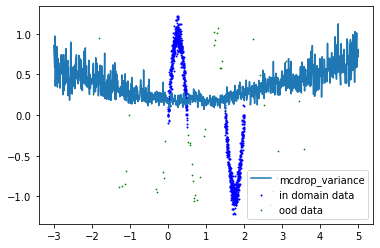

In [5]:
plt.scatter(x, y, color='b', s=1, label='in domain data')
plt.scatter(ood_x, ood_y, color='g', s=.5, label='ood data')
try:
    plt.plot(x_test, density_estimator.score_samples(x_test), label='density')
except:
    pass
plt.plot(x_test, variance_source.score_samples(x_test), label='mcdrop_variance')
# plt.plot(x_test, model.distance_estimator.score_samples(x_test), label='distance')

plt.legend()
plt.show()


In [7]:
epochs = 3
losses = {'a': [], 'e': [], 'f': []}

for i in range(epochs):
    print(i)
    new_losses = model.fit()
    for key in 'afe':
        losses[key].extend(new_losses[key])


0
1
2


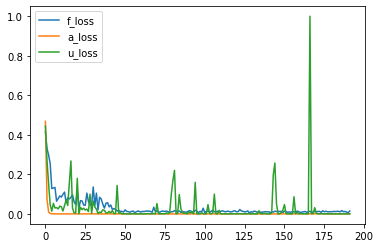

In [8]:
plt.plot(losses['f'], label='f_loss')
plt.plot(losses['a'], label='a_loss')
plt.plot(losses['e'], label='u_loss')
plt.legend()
plt.show()

In [9]:
predictions = networks['f_predictor'](x_test).detach().numpy().ravel()

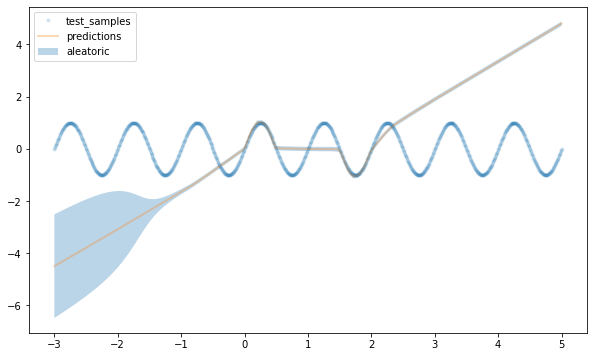

In [10]:
plt.figure(figsize=(10, 6))

aleatoric_u = networks['a_predictor'](x_test).detach().numpy().ravel()
a_low = predictions - np.sqrt(aleatoric_u)
a_high = predictions + np.sqrt(aleatoric_u)

plt.plot(x_test, y_test, '.', label='test_samples', alpha=.15)
plt.plot(x_test, predictions, label='predictions', alpha=.3, lw=2)
plt.fill_between(x_test.numpy().ravel(), a_low, a_high, alpha=.3, label='aleatoric')


epistemic_u = model._epistemic_uncertainty(x_test).detach().numpy().ravel()

e_low = predictions - np.sqrt(epistemic_u)
e_high = predictions + np.sqrt(epistemic_u)

# plt.fill_between(x_test.numpy().ravel(), e_low, e_high, alpha=.3, label='epistemic')

exp_epistemic_uncertainty = (networks['f_predictor'](x_test) - y_test).pow(2).detach().numpy().ravel()
exp_total_uncertainty = exp_epistemic_uncertainty + 0.1 ** 2  # squaring noise to get variance !!

exp_e_low = predictions - np.sqrt(exp_epistemic_uncertainty)
exp_e_high = predictions + np.sqrt(exp_epistemic_uncertainty)

# plt.fill_between(x_test.numpy().ravel(), exp_e_low, exp_e_high, alpha=.15, label='out of sample error')
plt.legend()
plt.show()

total_uncertainty = epistemic_u + aleatoric_u


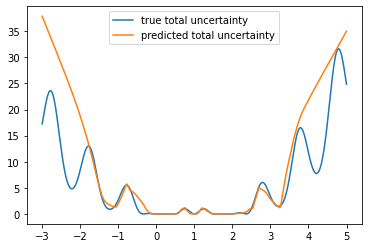

In [113]:
plt.plot(x_test, exp_total_uncertainty, label='true total uncertainty')
plt.plot(x_test, total_uncertainty, label='predicted total uncertainty')
plt.legend()
plt.show()

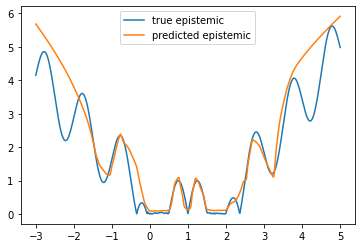

In [114]:
plt.plot(x_test.view(-1).numpy(), np.sqrt(exp_epistemic_uncertainty), label='true epistemic')
plt.plot(x_test.view(-1).numpy(), np.sqrt(epistemic_u), label='predicted epistemic')
# plt.plot(x_test, np.sqrt(epistemic_mcdrop), label='MCDropout epistemic')

plt.legend()
plt.show()

In [14]:
network = create_network(1, 1, 64, 'relu', False, dropout_prob=.4)
optimizer = create_optimizer(network, 1e-3, weight_decay=1e-4)

mcdropout = MCDropout(torch.cat([x, ood_x]), torch.cat([y, ood_y]), network, optimizer)
losses = []
for epoch in range(700):
    losses.append(mcdropout.fit()['f'])
plt.plot(losses)
epistemic_mcdrop = mcdropout._epistemic_uncertainty(x_test)

KeyboardInterrupt: 

In [50]:
model.e_predictor.input_layer.in_features

2